The purpose of this notebook is to create and train a model to guess the location of a streetview image in the continental US

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from skimage.io import imread
import time
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from math import radians, degrees, sin, cos, asin, acos, sqrt

In [13]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
#from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow
import torch
from tensorflow import keras

In [3]:
BASE_DIR = 'C:/Users/evan/Documents/Jupyter/GeoGuessr AI V3/'

#Latitude/Longitude Bounds for the continental US
min_lat = 25.84
max_lat = 49.38
min_lon = -124.67
max_lon = -66.95

#Calculates number of bins for latitudes/longitudes used in training
n_lats = len(np.unique(np.round(np.arange(min_lat, max_lat, 0.01))))
n_lons = len(np.unique(np.round(np.arange(min_lon, max_lon, 0.01))))

In [4]:
#Load training data
X_filenames = np.load('X.npy')
y_labels = np.load('y.npy')

In [5]:
#print shapes of training/testing data to ensure load/split worked correctly
X_train_filenames, X_val_filenames, y_train, y_val = train_test_split(X_filenames, y_labels, test_size=0.05, random_state=69)
print(X_train_filenames.shape, X_val_filenames.shape)

(64134,) (3376,)


In [6]:
#this generator class breaks up training data into batches so the model doesn't run out of VRAM while training
class My_Custom_Generator(keras.utils.Sequence):
  def __init__(self, image_filenames, labels, batch_size) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int32)
  
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
    return preprocess_input(np.array([
            imread(BASE_DIR + '/training_data/' + str(file_name))
               for file_name in batch_x])), np.array(batch_y)

In [7]:
#Initialize generator
batch_size = 8

my_training_batch_generator = My_Custom_Generator(X_train_filenames, y_train, batch_size)
my_validation_batch_generator = My_Custom_Generator(X_val_filenames, y_val, 128)

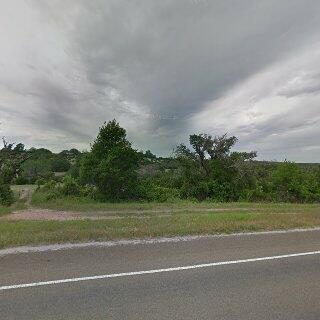

In [12]:
#an example of one of the images to be used in training
sample_image = imread(f'training_data/{X_train_filenames[1337]}')
Image.fromarray(sample_image)

In [ ]:
#Creating Neural Network model
n_classes = n_lats*n_lons

base_model = Xception(weights = 'imagenet', 
                      input_shape = sample_image.shape, 
                      include_top=False)

x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Flatten()(x)

x = Dense(1024, activation='relu')(x)

predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input , outputs=predictions)
model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
#Train the model
accHistory = []
for i in range(100):
    h = model.fit(x=my_training_batch_generator, epochs = 1, verbose = 1) 
    accHistory.append(h.history['accuracy'])
    model.save(f'Backups/Backup_{i+1}')

8017/8017 [==============================] - 1393s 174ms/step - loss: 6.7274 - accuracy: 0.0018
INFO:tensorflow:Assets written to: Backups/Backup_1\assets
8017/8017 [==============================] - 1389s 173ms/step - loss: 6.2847 - accuracy: 0.0053
INFO:tensorflow:Assets written to: Backups/Backup_2\assets
8017/8017 [==============================] - 1433s 179ms/step - loss: 6.0150 - accuracy: 0.0088
INFO:tensorflow:Assets written to: Backups/Backup_3\assets
8017/8017 [==============================] - 1402s 175ms/step - loss: 5.7518 - accuracy: 0.0162
INFO:tensorflow:Assets written to: Backups/Backup_4\assets
8017/8017 [==============================] - 1383s 172ms/step - loss: 5.5182 - accuracy: 0.0237
INFO:tensorflow:Assets written to: Backups/Backup_5\assets
8017/8017 [==============================] - 1353s 169ms/step - loss: 5.3249 - accuracy: 0.0301
INFO:tensorflow:Assets written to: Backups/Backup_6\assets
8017/8017 [==============================] - 1351s 168ms/step - loss: 

KeyboardInterrupt: 

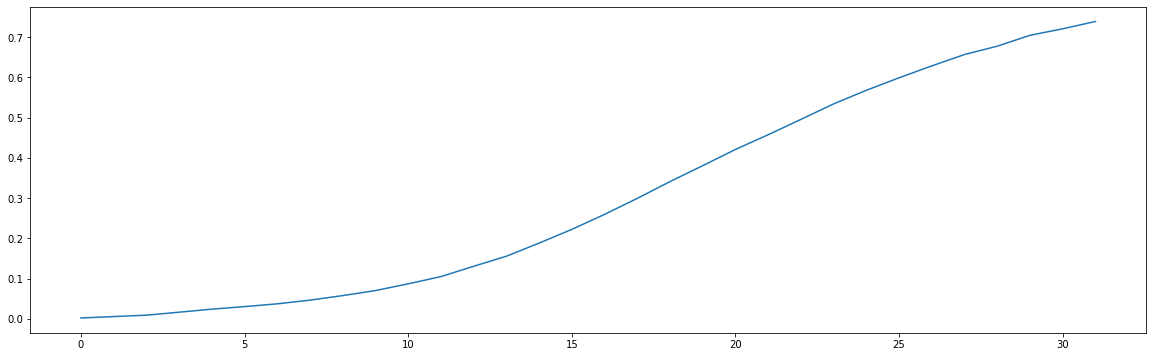

In [20]:
#A Graph of the training accuracy by training epoch
fig, ax = plt.subplots(1,1,figsize=(20,6))
ax.plot(range(len(accHistory)), accHistory)